In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
REWEIGHT = True
EPOCHS = 500
BATCH_SIZE = 128
ENABLE_TPU = True
LEARNING_RATE = 0.1   # 0.15(default), 0.1

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 500
	TPU Enabled: True


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/869.5 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 860.2/869.5 kB 14.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 11.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 2937, done.


remote: Counting objects: 100% (862/862), done.


remote: Compressing objects: 100% (348/348), done.


remote: Total 2937 (delta 537), reused 832 (delta 514), pack-reused 2075 (from 1)
Receiving objects: 100% (2937/2937), 1.05 GiB | 29.74 MiB/s, done.


Resolving deltas: 100% (1562/1562), done.


Updating files: 100% (226/226), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
# from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


TPU is Enabled


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1728662771.356926      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR10...



  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:49, 362744.87it/s]

  0%|          | 229376/170498071 [00:00<04:11, 676649.92it/s]

  0%|          | 524288/170498071 [00:00<02:02, 1388611.28it/s]

  1%|          | 1114112/170498071 [00:00<01:01, 2774816.13it/s]

  1%|▏         | 2392064/170498071 [00:00<00:28, 5812172.07it/s]

  2%|▏         | 4096000/170498071 [00:00<00:18, 9210372.41it/s]

  4%|▎         | 6062080/170498071 [00:00<00:13, 12327365.15it/s]

  5%|▍         | 8159232/170498071 [00:00<00:10, 14908880.57it/s]

  6%|▌         | 10420224/170498071 [00:01<00:09, 17209778.97it/s]

  7%|▋         | 12648448/170498071 [00:01<00:08, 18695909.65it/s]

  9%|▉         | 15040512/170498071 [00:01<00:07, 20245360.40it/s]

 10%|█         | 17498112/170498071 [00:01<00:07, 21533972.49it/s]

 12%|█▏        | 20152320/170498071 [00:01<00:06, 22906836.96it/s]

 13%|█▎        | 22872064/170498071 [00:01<00:06, 24120447.37it/s]

 15%|█▌        | 25821184/170498071 [00:01<00:05, 25721656.91it/s]

 17%|█▋        | 28999680/170498071 [00:01<00:05, 27479810.73it/s]

 19%|█▊        | 31916032/170498071 [00:01<00:04, 27955686.82it/s]

 20%|██        | 34897920/170498071 [00:01<00:04, 27610886.70it/s]

 22%|██▏       | 37912576/170498071 [00:02<00:04, 28298694.15it/s]

 24%|██▍       | 40894464/170498071 [00:02<00:04, 28677861.16it/s]

 26%|██▌       | 43909120/170498071 [00:02<00:04, 29015873.82it/s]

 28%|██▊       | 46891008/170498071 [00:02<00:04, 29215483.35it/s]

 29%|██▉       | 49840128/170498071 [00:02<00:04, 29268661.05it/s]

 31%|███       | 52854784/170498071 [00:02<00:03, 29464425.67it/s]

 33%|███▎      | 56295424/170498071 [00:02<00:03, 30832555.02it/s]

 35%|███▍      | 59473920/170498071 [00:02<00:03, 31015161.43it/s]

 37%|███▋      | 62586880/170498071 [00:02<00:03, 29781933.94it/s]

 39%|███▊      | 65732608/170498071 [00:03<00:03, 30130152.84it/s]

 40%|████      | 68780032/170498071 [00:03<00:03, 30129992.08it/s]

 42%|████▏     | 71827456/170498071 [00:03<00:03, 29970864.44it/s]

 44%|████▍     | 74842112/170498071 [00:03<00:03, 29775406.73it/s]

 46%|████▌     | 77856768/170498071 [00:03<00:03, 29800837.58it/s]

 47%|████▋     | 80871424/170498071 [00:03<00:03, 29697199.22it/s]

 49%|████▉     | 83886080/170498071 [00:03<00:02, 29780362.89it/s]

 51%|█████     | 86867968/170498071 [00:03<00:02, 29423332.93it/s]

 53%|█████▎    | 89817088/170498071 [00:03<00:02, 29243172.53it/s]

 54%|█████▍    | 92766208/170498071 [00:03<00:02, 29107689.23it/s]

 56%|█████▌    | 95682560/170498071 [00:04<00:02, 28963951.12it/s]

 58%|█████▊    | 98598912/170498071 [00:04<00:02, 28811440.54it/s]

 60%|█████▉    | 101482496/170498071 [00:04<00:02, 28736227.85it/s]

 61%|██████    | 104366080/170498071 [00:04<00:02, 28705879.18it/s]

 63%|██████▎   | 107249664/170498071 [00:04<00:02, 28242279.61it/s]

 65%|██████▍   | 110133248/170498071 [00:04<00:02, 28376913.41it/s]

 66%|██████▋   | 112984064/170498071 [00:04<00:02, 28376380.64it/s]

 68%|██████▊   | 115900416/170498071 [00:04<00:01, 28590150.96it/s]

 70%|██████▉   | 118784000/170498071 [00:04<00:01, 28514350.17it/s]

 71%|███████▏  | 121700352/170498071 [00:04<00:01, 28587069.75it/s]

 73%|███████▎  | 124583936/170498071 [00:05<00:01, 23953521.88it/s]

 75%|███████▍  | 127107072/170498071 [00:05<00:01, 24133088.75it/s]

 76%|███████▌  | 129630208/170498071 [00:05<00:01, 24249571.17it/s]

 77%|███████▋  | 132120576/170498071 [00:05<00:01, 24407813.61it/s]

 79%|███████▉  | 134610944/170498071 [00:05<00:01, 24541380.28it/s]

 80%|████████  | 137166848/170498071 [00:05<00:01, 24665842.96it/s]

 82%|████████▏ | 139722752/170498071 [00:05<00:01, 24907556.09it/s]

 83%|████████▎ | 142311424/170498071 [00:05<00:01, 25190235.43it/s]

 85%|████████▌ | 144998400/170498071 [00:05<00:00, 25556605.45it/s]

 87%|████████▋ | 147587072/170498071 [00:06<00:00, 25435530.92it/s]

 88%|████████▊ | 150306816/170498071 [00:06<00:00, 25918513.36it/s]

 90%|████████▉ | 152961024/170498071 [00:06<00:00, 26087346.08it/s]

 91%|█████████▏| 155713536/170498071 [00:06<00:00, 26381925.27it/s]

 93%|█████████▎| 158564352/170498071 [00:06<00:00, 26860680.29it/s]

 95%|█████████▍| 161415168/170498071 [00:06<00:00, 27245982.22it/s]

 96%|█████████▋| 164233216/170498071 [00:06<00:00, 27496517.87it/s]

 98%|█████████▊| 167084032/170498071 [00:06<00:00, 27794014.94it/s]

100%|█████████▉| 169934848/170498071 [00:06<00:00, 27908562.85it/s]

100%|██████████| 170498071/170498071 [00:06<00:00, 24880436.33it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:52, 360531.55it/s]

  0%|          | 229376/170498071 [00:00<04:11, 676469.66it/s]

  1%|          | 917504/170498071 [00:00<01:21, 2088747.04it/s]

  2%|▏         | 2686976/170498071 [00:00<00:27, 6195421.30it/s]

  3%|▎         | 5636096/170498071 [00:00<00:13, 12542213.26it/s]

  5%|▌         | 8912896/170498071 [00:00<00:08, 18195637.14it/s]

  7%|▋         | 12550144/170498071 [00:00<00:06, 23389241.39it/s]

  9%|▉         | 15564800/170498071 [00:01<00:06, 25285770.84it/s]

 11%|█         | 18972672/170498071 [00:01<00:06, 24535072.64it/s]

 13%|█▎        | 22183936/170498071 [00:01<00:05, 26436363.41it/s]

 15%|█▌        | 25919488/170498071 [00:01<00:04, 29431811.42it/s]

 17%|█▋        | 29360128/170498071 [00:01<00:04, 30812943.55it/s]

 19%|█▉        | 32964608/170498071 [00:01<00:04, 32275868.98it/s]

 21%|██▏       | 36274176/170498071 [00:01<00:04, 32334575.29it/s]

 23%|██▎       | 39583744/170498071 [00:01<00:04, 32152188.88it/s]

 25%|██▌       | 43220992/170498071 [00:01<00:03, 33348604.00it/s]

 27%|██▋       | 46858240/170498071 [00:02<00:03, 34167128.75it/s]

 30%|██▉       | 50298880/170498071 [00:02<00:03, 30913967.73it/s]

 31%|███▏      | 53542912/170498071 [00:02<00:03, 31012637.19it/s]

 33%|███▎      | 56918016/170498071 [00:02<00:03, 31167350.16it/s]

 36%|███▌      | 60588032/170498071 [00:02<00:03, 32704521.70it/s]

 38%|███▊      | 64290816/170498071 [00:02<00:03, 33933372.78it/s]

 40%|███▉      | 67796992/170498071 [00:02<00:03, 33391299.47it/s]

 42%|████▏     | 71172096/170498071 [00:02<00:02, 33219330.54it/s]

 44%|████▍     | 74874880/170498071 [00:02<00:02, 34303985.83it/s]

 46%|████▌     | 78348288/170498071 [00:02<00:02, 34060260.44it/s]

 48%|████▊     | 81788928/170498071 [00:03<00:02, 32554900.44it/s]

 50%|████▉     | 85065728/170498071 [00:03<00:02, 31786212.92it/s]

 52%|█████▏    | 88342528/170498071 [00:03<00:02, 32015025.61it/s]

 54%|█████▎    | 91586560/170498071 [00:03<00:02, 31908405.50it/s]

 56%|█████▌    | 94994432/170498071 [00:03<00:02, 32503486.13it/s]

 58%|█████▊    | 98697216/170498071 [00:03<00:02, 33824448.99it/s]

 60%|█████▉    | 102105088/170498071 [00:03<00:02, 33543200.78it/s]

 62%|██████▏   | 105709568/170498071 [00:03<00:01, 34226915.02it/s]

 64%|██████▍   | 109150208/170498071 [00:03<00:01, 33095904.18it/s]

 66%|██████▌   | 112852992/170498071 [00:04<00:01, 34229790.61it/s]

 68%|██████▊   | 116293632/170498071 [00:04<00:01, 33639206.06it/s]

 70%|███████   | 119668736/170498071 [00:04<00:01, 32480696.19it/s]

 72%|███████▏  | 122945536/170498071 [00:04<00:01, 31814726.12it/s]

 74%|███████▍  | 126222336/170498071 [00:04<00:01, 31949710.69it/s]

 76%|███████▌  | 129531904/170498071 [00:04<00:01, 32265696.88it/s]

 78%|███████▊  | 132841472/170498071 [00:04<00:01, 31921938.41it/s]

 80%|███████▉  | 136314880/170498071 [00:04<00:01, 32661162.67it/s]

 82%|████████▏ | 139919360/170498071 [00:04<00:00, 33627934.32it/s]

 84%|████████▍ | 143491072/170498071 [00:04<00:00, 34223500.54it/s]

 86%|████████▌ | 147030016/170498071 [00:05<00:00, 33751204.68it/s]

 88%|████████▊ | 150437888/170498071 [00:05<00:00, 33762503.65it/s]

 90%|█████████ | 153976832/170498071 [00:05<00:00, 34240409.15it/s]

 92%|█████████▏| 157417472/170498071 [00:05<00:00, 33589365.39it/s]

 94%|█████████▍| 160792576/170498071 [00:05<00:00, 32375506.04it/s]

 96%|█████████▌| 164069376/170498071 [00:05<00:00, 32173326.52it/s]

 98%|█████████▊| 167313408/170498071 [00:05<00:00, 31847723.87it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29441652.08it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:51, 361163.95it/s]

  0%|          | 229376/170498071 [00:00<04:10, 678890.40it/s]

  1%|          | 917504/170498071 [00:00<01:20, 2094922.87it/s]

  2%|▏         | 2785280/170498071 [00:00<00:25, 6457166.95it/s]

  3%|▎         | 5832704/170498071 [00:00<00:12, 13019154.20it/s]

  6%|▌         | 9469952/170498071 [00:00<00:08, 19565584.76it/s]

  8%|▊         | 13074432/170498071 [00:01<00:07, 20986977.97it/s]

 10%|▉         | 16809984/170498071 [00:01<00:06, 25227336.93it/s]

 12%|█▏        | 20185088/170498071 [00:01<00:05, 27536997.87it/s]

 14%|█▍        | 23461888/170498071 [00:01<00:05, 28740261.32it/s]

 16%|█▌        | 27230208/170498071 [00:01<00:04, 31263487.85it/s]

 18%|█▊        | 30998528/170498071 [00:01<00:04, 33094347.62it/s]

 20%|██        | 34537472/170498071 [00:01<00:04, 33750511.84it/s]

 22%|██▏       | 38010880/170498071 [00:01<00:04, 31392304.68it/s]

 24%|██▍       | 41713664/170498071 [00:01<00:03, 32799150.02it/s]

 26%|██▋       | 45121536/170498071 [00:01<00:03, 32838485.11it/s]

 28%|██▊       | 48463872/170498071 [00:02<00:03, 30935981.43it/s]

 31%|███       | 52199424/170498071 [00:02<00:03, 32695481.33it/s]

 33%|███▎      | 55705600/170498071 [00:02<00:03, 33359759.48it/s]

 35%|███▍      | 59408384/170498071 [00:02<00:03, 33094578.20it/s]

 37%|███▋      | 63143936/170498071 [00:02<00:03, 34284623.48it/s]

 39%|███▉      | 66879488/170498071 [00:02<00:02, 35057548.41it/s]

 41%|████▏     | 70418432/170498071 [00:02<00:03, 31131103.03it/s]

 43%|████▎     | 73695232/170498071 [00:02<00:03, 31396021.29it/s]

 45%|████▌     | 77496320/170498071 [00:02<00:02, 33196608.87it/s]

 48%|████▊     | 81264640/170498071 [00:03<00:02, 34445767.34it/s]

 50%|████▉     | 84770816/170498071 [00:03<00:02, 33718913.28it/s]

 52%|█████▏    | 88211456/170498071 [00:03<00:02, 33836486.51it/s]

 54%|█████▍    | 91750400/170498071 [00:03<00:02, 33075623.45it/s]

 56%|█████▌    | 95191040/170498071 [00:03<00:02, 33158098.07it/s]

 58%|█████▊    | 98566144/170498071 [00:03<00:02, 33248723.64it/s]

 60%|█████▉    | 101908480/170498071 [00:03<00:02, 33121201.09it/s]

 62%|██████▏   | 105250816/170498071 [00:03<00:02, 31269643.61it/s]

 64%|██████▍   | 108986368/170498071 [00:03<00:01, 32982214.70it/s]

 66%|██████▌   | 112656384/170498071 [00:03<00:01, 34033805.03it/s]

 68%|██████▊   | 116097024/170498071 [00:04<00:01, 33627593.77it/s]

 70%|███████   | 119504896/170498071 [00:04<00:01, 33410301.87it/s]

 72%|███████▏  | 123273216/170498071 [00:04<00:01, 34640705.42it/s]

 74%|███████▍  | 126812160/170498071 [00:04<00:01, 34534209.12it/s]

 76%|███████▋  | 130285568/170498071 [00:04<00:01, 31485352.29it/s]

 78%|███████▊  | 133627904/170498071 [00:04<00:01, 31785160.39it/s]

 80%|████████  | 136970240/170498071 [00:04<00:01, 32226603.87it/s]

 82%|████████▏ | 140345344/170498071 [00:04<00:00, 32646678.95it/s]

 85%|████████▍ | 144113664/170498071 [00:04<00:00, 34076468.29it/s]

 87%|████████▋ | 147849216/170498071 [00:05<00:00, 34944077.16it/s]

 89%|████████▉ | 151388160/170498071 [00:05<00:00, 33878592.86it/s]

 91%|█████████ | 154927104/170498071 [00:05<00:00, 34310465.97it/s]

 93%|█████████▎| 158400512/170498071 [00:05<00:00, 32754415.78it/s]

 95%|█████████▍| 161808384/170498071 [00:05<00:00, 32952228.05it/s]

 97%|█████████▋| 165150720/170498071 [00:05<00:00, 32102283.84it/s]

 99%|█████████▉| 168394752/170498071 [00:05<00:00, 31968982.26it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29850734.84it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    CustomTrivialAugmentWide(custom=True, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
)


Dataset type "custom" displaying...



truck: 1.00 frog : 1.00 airplane: 0.96 cat  : 0.89 automobile: 0.98 ship : 1.00 horse: 1.00 frog : 1.00 bird : 0.99 truck: 1.00 bird : 0.95 ship : 0.86 horse: 1.00 ship : 1.00 cat  : 0.98 truck: 1.00 bird : 1.00 airplane: 1.00 airplane: 1.00 frog : 1.00 deer : 0.86 automobile: 0.99 frog : 1.00 truck: 0.97 ship : 0.86 automobile: 0.63 bird : 0.84 cat  : 1.00 cat  : 1.00 ship : 0.86 horse: 1.00 ship : 1.00 truck: 1.00 airplane: 1.00 deer : 0.99 cat  : 0.99 cat  : 1.00 airplane: 1.00 airplane: 0.96 horse: 1.00 automobile: 0.97 dog  : 1.00 deer : 0.27 airplane: 1.00 airplane: 1.00 ship : 1.00 truck: 0.95 cat  : 1.00 airplane: 1.00 ship : 1.00 ship : 1.00 truck: 0.91 cat  : 0.86 deer : 1.00 cat  : 0.93 truck: 1.00 dog  : 1.00 bird : 0.97 frog : 1.00 bird : 0.86 ship : 1.00 airplane: 1.00 ship : 1.00 bird : 1.00 automobile: 0.86 ship : 1.00 airplane: 0.48 deer : 0.86 ship : 1.00 cat  : 0.87 truck: 1.00 dog  : 0.48 bird : 1.00 dog  : 0.95 dog  : 0.87 horse: 1.00 dog  : 1.00 dog  : 1.00 truck:

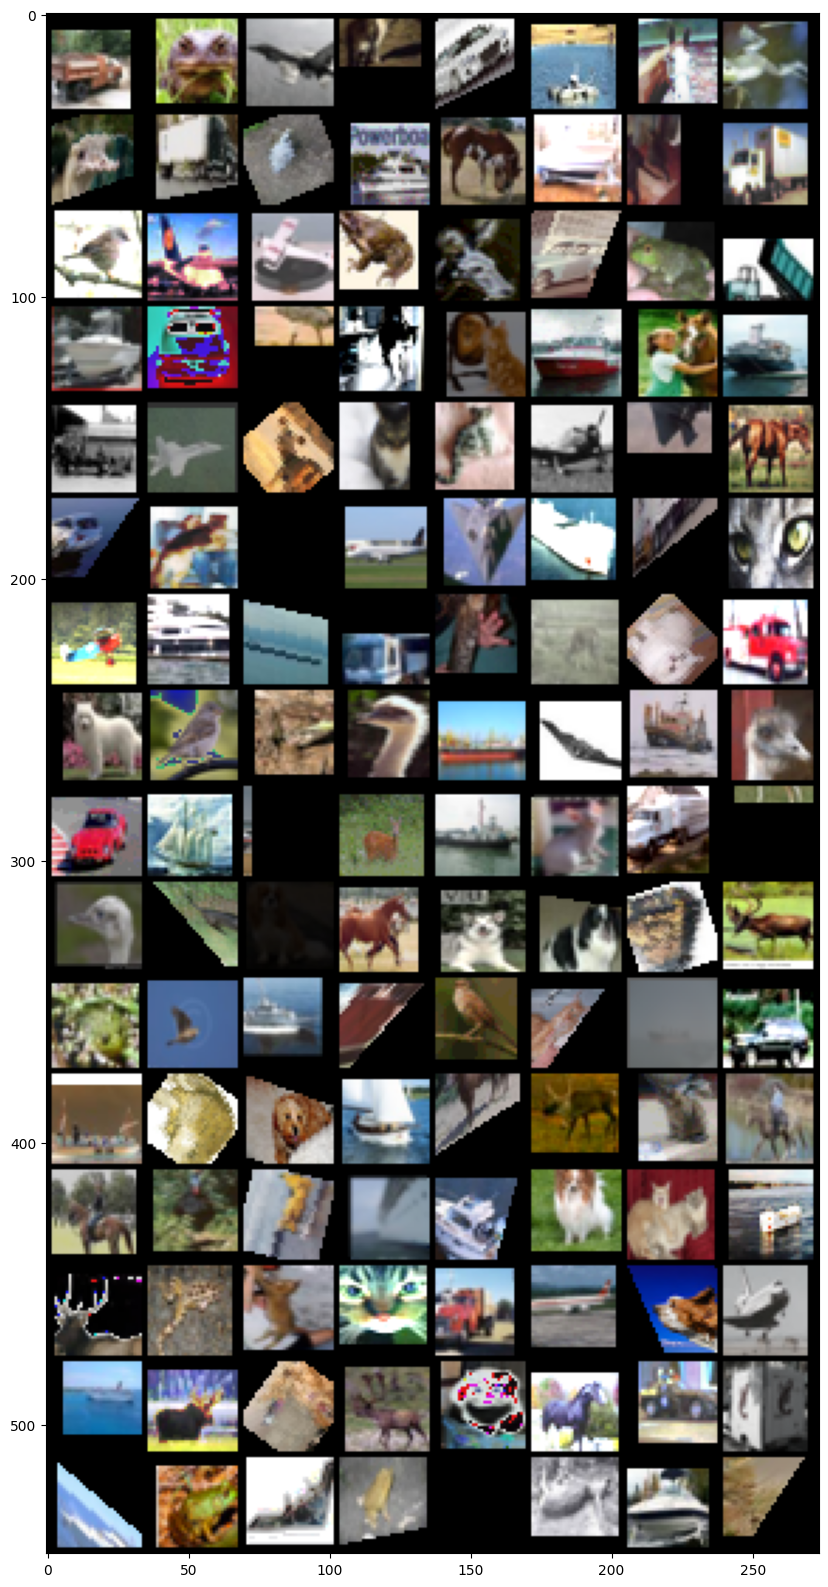

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

## Define WideResNet 28_4

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
def soft_loss(pred, label, confidence, reweight=False):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1).float()
    # soft one_hot
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    
    # hard one_hot
#     one_hot = torch.zeros_like(pred)
#     one_hot.scatter_(dim=1, index=label, value=1.0)
    # Compute weighted KL loss
    kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl = kl.unsqueeze(1)  # Unweighted
    if reweight:
        kl = confidence * kl  # Weighted
    return kl.mean()

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    if DATASET_TYPE=='baseline':
        trainloader = baseline_trainloader
    elif DATASET_TYPE=='custom':
        trainloader = custom_trainloader
    else:
        raise ValueError('Dataset type is not Valid!')
    
    for i, data in enumerate(trainloader):
            
        if DATASET_TYPE=='baseline':
            inputs, labels = data
        elif DATASET_TYPE=='custom':
            inputs, labels, confidences = data
            # get the inputs
            """when the model returns [augmentation_magnitude, confidence_aa], which is the case
            only when TA with soft labels is applied."""
            if isinstance(confidences, list):
                confidences = confidences[1]
            confidences = confidences.to(device)
        else:
            raise ValueError('Dataset type is not Valid!')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.to(device)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences, reweight=REWEIGHT)
        else:
            loss = criterion(outputs, labels)
        
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 1.610 - Test Accuracy:  32.910

Processing time:  73.926963 seconds.



Epoch 2 - Loss: 1.295 - Test Accuracy:  50.090

Processing time:  46.950391 seconds.



Epoch 3 - Loss: 1.116 - Test Accuracy:  62.320

Processing time:  36.357023 seconds.



Epoch 4 - Loss: 0.995 - Test Accuracy:  59.130

Processing time:  35.802318 seconds.



Epoch 5 - Loss: 0.911 - Test Accuracy:  55.100

Processing time:  35.646555 seconds.



Epoch 6 - Loss: 0.844 - Test Accuracy:  67.230

Processing time:  35.681462 seconds.



Epoch 7 - Loss: 0.787 - Test Accuracy:  68.470

Processing time:  35.860767 seconds.



Epoch 8 - Loss: 0.742 - Test Accuracy:  74.220

Processing time:  36.633366 seconds.



Epoch 9 - Loss: 0.706 - Test Accuracy:  76.560

Processing time:  35.440180 seconds.



Epoch 10 - Loss: 0.671 - Test Accuracy:  79.700

Processing time:  35.832926 seconds.



Epoch 11 - Loss: 0.647 - Test Accuracy:  82.380

Processing time:  35.791954 seconds.



Epoch 12 - Loss: 0.619 - Test Accuracy:  80.650

Processing time:  35.905327 seconds.



Epoch 13 - Loss: 0.602 - Test Accuracy:  80.040

Processing time:  35.342084 seconds.



Epoch 14 - Loss: 0.583 - Test Accuracy:  83.510

Processing time:  35.412177 seconds.



Epoch 15 - Loss: 0.567 - Test Accuracy:  80.880

Processing time:  35.300671 seconds.



Epoch 16 - Loss: 0.554 - Test Accuracy:  84.910

Processing time:  35.569736 seconds.



Epoch 17 - Loss: 0.541 - Test Accuracy:  82.470

Processing time:  35.682949 seconds.



Epoch 18 - Loss: 0.534 - Test Accuracy:  83.300

Processing time:  36.323113 seconds.



Epoch 19 - Loss: 0.522 - Test Accuracy:  82.370

Processing time:  35.779745 seconds.



Epoch 20 - Loss: 0.506 - Test Accuracy:  82.250

Processing time:  35.532222 seconds.



Epoch 21 - Loss: 0.504 - Test Accuracy:  86.500

Processing time:  35.609009 seconds.



Epoch 22 - Loss: 0.492 - Test Accuracy:  84.130

Processing time:  35.261201 seconds.



Epoch 23 - Loss: 0.487 - Test Accuracy:  85.870

Processing time:  35.622810 seconds.



Epoch 24 - Loss: 0.486 - Test Accuracy:  85.710

Processing time:  35.572499 seconds.



Epoch 25 - Loss: 0.476 - Test Accuracy:  83.120

Processing time:  36.582421 seconds.



Epoch 26 - Loss: 0.475 - Test Accuracy:  87.290

Processing time:  35.153585 seconds.



Epoch 27 - Loss: 0.467 - Test Accuracy:  87.750

Processing time:  35.205230 seconds.



Epoch 28 - Loss: 0.456 - Test Accuracy:  89.100

Processing time:  34.659797 seconds.



Epoch 29 - Loss: 0.460 - Test Accuracy:  86.350

Processing time:  34.818941 seconds.



Epoch 30 - Loss: 0.451 - Test Accuracy:  85.340

Processing time:  34.868096 seconds.



Epoch 31 - Loss: 0.449 - Test Accuracy:  88.380

Processing time:  35.131391 seconds.



Epoch 32 - Loss: 0.440 - Test Accuracy:  86.160

Processing time:  35.820267 seconds.



Epoch 33 - Loss: 0.441 - Test Accuracy:  88.890

Processing time:  35.263795 seconds.



Epoch 34 - Loss: 0.437 - Test Accuracy:  88.640

Processing time:  34.683808 seconds.



Epoch 35 - Loss: 0.433 - Test Accuracy:  87.860

Processing time:  34.550484 seconds.



Epoch 36 - Loss: 0.433 - Test Accuracy:  88.480

Processing time:  34.735423 seconds.



Epoch 37 - Loss: 0.424 - Test Accuracy:  89.760

Processing time:  34.556170 seconds.



Epoch 38 - Loss: 0.422 - Test Accuracy:  89.420

Processing time:  35.023118 seconds.



Epoch 39 - Loss: 0.423 - Test Accuracy:  87.250

Processing time:  35.086998 seconds.



Epoch 40 - Loss: 0.423 - Test Accuracy:  88.890

Processing time:  34.301541 seconds.



Epoch 41 - Loss: 0.413 - Test Accuracy:  88.350

Processing time:  34.283081 seconds.



Epoch 42 - Loss: 0.413 - Test Accuracy:  89.730

Processing time:  34.606020 seconds.



Epoch 43 - Loss: 0.413 - Test Accuracy:  90.120

Processing time:  35.528935 seconds.



Epoch 44 - Loss: 0.403 - Test Accuracy:  86.200

Processing time:  34.524764 seconds.



Epoch 45 - Loss: 0.401 - Test Accuracy:  87.020

Processing time:  34.318234 seconds.



Epoch 46 - Loss: 0.401 - Test Accuracy:  88.020

Processing time:  36.300828 seconds.



Epoch 47 - Loss: 0.398 - Test Accuracy:  90.490

Processing time:  36.688569 seconds.



Epoch 48 - Loss: 0.400 - Test Accuracy:  90.300

Processing time:  34.551157 seconds.



Epoch 49 - Loss: 0.394 - Test Accuracy:  90.000

Processing time:  35.027561 seconds.



Epoch 50 - Loss: 0.392 - Test Accuracy:  90.340

Processing time:  34.828156 seconds.



Epoch 51 - Loss: 0.391 - Test Accuracy:  89.270

Processing time:  36.989040 seconds.



Epoch 52 - Loss: 0.386 - Test Accuracy:  89.050

Processing time:  34.952192 seconds.



Epoch 53 - Loss: 0.394 - Test Accuracy:  87.980

Processing time:  34.884124 seconds.



Epoch 54 - Loss: 0.389 - Test Accuracy:  90.460

Processing time:  36.501331 seconds.



Epoch 55 - Loss: 0.381 - Test Accuracy:  91.690

Processing time:  35.604122 seconds.



Epoch 56 - Loss: 0.382 - Test Accuracy:  91.180

Processing time:  35.685430 seconds.



Epoch 57 - Loss: 0.382 - Test Accuracy:  89.170

Processing time:  34.734420 seconds.



Epoch 58 - Loss: 0.377 - Test Accuracy:  89.650

Processing time:  35.267500 seconds.



Epoch 59 - Loss: 0.382 - Test Accuracy:  90.770

Processing time:  35.909335 seconds.



Epoch 60 - Loss: 0.378 - Test Accuracy:  90.610

Processing time:  35.908640 seconds.



Epoch 61 - Loss: 0.374 - Test Accuracy:  86.850

Processing time:  36.369560 seconds.



Epoch 62 - Loss: 0.374 - Test Accuracy:  88.520

Processing time:  35.966823 seconds.



Epoch 63 - Loss: 0.371 - Test Accuracy:  91.420

Processing time:  35.844023 seconds.



Epoch 64 - Loss: 0.369 - Test Accuracy:  87.890

Processing time:  35.998037 seconds.



Epoch 65 - Loss: 0.367 - Test Accuracy:  90.600

Processing time:  35.387841 seconds.



Epoch 66 - Loss: 0.371 - Test Accuracy:  90.890

Processing time:  36.422404 seconds.



Epoch 67 - Loss: 0.366 - Test Accuracy:  89.410

Processing time:  35.576377 seconds.



Epoch 68 - Loss: 0.363 - Test Accuracy:  89.260

Processing time:  35.864941 seconds.



Epoch 69 - Loss: 0.367 - Test Accuracy:  89.150

Processing time:  35.873006 seconds.



Epoch 70 - Loss: 0.369 - Test Accuracy:  90.260

Processing time:  34.399642 seconds.



Epoch 71 - Loss: 0.361 - Test Accuracy:  90.570

Processing time:  36.023424 seconds.



Epoch 72 - Loss: 0.359 - Test Accuracy:  89.740

Processing time:  35.684077 seconds.



Epoch 73 - Loss: 0.357 - Test Accuracy:  88.810

Processing time:  35.472459 seconds.



Epoch 74 - Loss: 0.359 - Test Accuracy:  88.760

Processing time:  34.756303 seconds.



Epoch 75 - Loss: 0.359 - Test Accuracy:  90.670

Processing time:  34.589059 seconds.



Epoch 76 - Loss: 0.357 - Test Accuracy:  89.190

Processing time:  34.389818 seconds.



Epoch 77 - Loss: 0.360 - Test Accuracy:  91.840

Processing time:  34.643201 seconds.



Epoch 78 - Loss: 0.357 - Test Accuracy:  90.910

Processing time:  34.458743 seconds.



Epoch 79 - Loss: 0.349 - Test Accuracy:  90.080

Processing time:  34.914707 seconds.



Epoch 80 - Loss: 0.351 - Test Accuracy:  91.110

Processing time:  35.202395 seconds.



Epoch 81 - Loss: 0.355 - Test Accuracy:  90.310

Processing time:  35.798648 seconds.



Epoch 82 - Loss: 0.350 - Test Accuracy:  91.230

Processing time:  34.341619 seconds.



Epoch 83 - Loss: 0.353 - Test Accuracy:  91.660

Processing time:  34.561348 seconds.



Epoch 84 - Loss: 0.354 - Test Accuracy:  91.590

Processing time:  35.024438 seconds.



Epoch 85 - Loss: 0.344 - Test Accuracy:  92.060

Processing time:  34.503364 seconds.



Epoch 86 - Loss: 0.350 - Test Accuracy:  89.220

Processing time:  35.856040 seconds.



Epoch 87 - Loss: 0.342 - Test Accuracy:  90.750

Processing time:  35.256084 seconds.



Epoch 88 - Loss: 0.343 - Test Accuracy:  89.220

Processing time:  34.522379 seconds.



Epoch 89 - Loss: 0.347 - Test Accuracy:  91.970

Processing time:  35.397810 seconds.



Epoch 90 - Loss: 0.346 - Test Accuracy:  91.890

Processing time:  34.369121 seconds.



Epoch 91 - Loss: 0.338 - Test Accuracy:  88.740

Processing time:  36.447633 seconds.



Epoch 92 - Loss: 0.344 - Test Accuracy:  91.240

Processing time:  35.932440 seconds.



Epoch 93 - Loss: 0.338 - Test Accuracy:  90.280

Processing time:  35.972363 seconds.



Epoch 94 - Loss: 0.345 - Test Accuracy:  91.310

Processing time:  34.894747 seconds.



Epoch 95 - Loss: 0.339 - Test Accuracy:  91.650

Processing time:  34.843658 seconds.



Epoch 96 - Loss: 0.342 - Test Accuracy:  90.640

Processing time:  35.881174 seconds.



Epoch 97 - Loss: 0.335 - Test Accuracy:  91.130

Processing time:  36.407147 seconds.



Epoch 98 - Loss: 0.336 - Test Accuracy:  91.770

Processing time:  36.534686 seconds.



Epoch 99 - Loss: 0.339 - Test Accuracy:  89.420

Processing time:  36.495178 seconds.



Epoch 100 - Loss: 0.337 - Test Accuracy:  90.890

Processing time:  36.126810 seconds.



Epoch 101 - Loss: 0.335 - Test Accuracy:  91.960

Processing time:  36.111730 seconds.



Epoch 102 - Loss: 0.335 - Test Accuracy:  91.320

Processing time:  36.452943 seconds.



Epoch 103 - Loss: 0.334 - Test Accuracy:  91.140

Processing time:  36.179476 seconds.



Epoch 104 - Loss: 0.329 - Test Accuracy:  92.400

Processing time:  36.431172 seconds.



Epoch 105 - Loss: 0.331 - Test Accuracy:  89.560

Processing time:  36.311639 seconds.



Epoch 106 - Loss: 0.336 - Test Accuracy:  91.980

Processing time:  35.543440 seconds.



Epoch 107 - Loss: 0.327 - Test Accuracy:  91.340

Processing time:  35.313378 seconds.



Epoch 108 - Loss: 0.330 - Test Accuracy:  91.700

Processing time:  35.448740 seconds.



Epoch 109 - Loss: 0.329 - Test Accuracy:  91.620

Processing time:  34.954451 seconds.



Epoch 110 - Loss: 0.328 - Test Accuracy:  90.120

Processing time:  34.555935 seconds.



Epoch 111 - Loss: 0.327 - Test Accuracy:  90.890

Processing time:  35.610479 seconds.



Epoch 112 - Loss: 0.325 - Test Accuracy:  90.300

Processing time:  34.641890 seconds.



Epoch 113 - Loss: 0.325 - Test Accuracy:  90.800

Processing time:  35.932192 seconds.



Epoch 114 - Loss: 0.328 - Test Accuracy:  91.960

Processing time:  37.160528 seconds.



Epoch 115 - Loss: 0.331 - Test Accuracy:  92.350

Processing time:  35.881789 seconds.



Epoch 116 - Loss: 0.324 - Test Accuracy:  92.130

Processing time:  35.484002 seconds.



Epoch 117 - Loss: 0.323 - Test Accuracy:  90.820

Processing time:  35.541976 seconds.



Epoch 118 - Loss: 0.323 - Test Accuracy:  90.410

Processing time:  35.054556 seconds.



Epoch 119 - Loss: 0.321 - Test Accuracy:  92.110

Processing time:  36.181447 seconds.



Epoch 120 - Loss: 0.318 - Test Accuracy:  89.690

Processing time:  35.791912 seconds.



Epoch 121 - Loss: 0.322 - Test Accuracy:  91.460

Processing time:  35.589953 seconds.



Epoch 122 - Loss: 0.319 - Test Accuracy:  89.440

Processing time:  35.649627 seconds.



Epoch 123 - Loss: 0.321 - Test Accuracy:  92.300

Processing time:  35.827410 seconds.



Epoch 124 - Loss: 0.321 - Test Accuracy:  90.500

Processing time:  35.439347 seconds.



Epoch 125 - Loss: 0.321 - Test Accuracy:  90.790

Processing time:  34.839901 seconds.



Epoch 126 - Loss: 0.323 - Test Accuracy:  91.520

Processing time:  34.899053 seconds.



Epoch 127 - Loss: 0.316 - Test Accuracy:  91.120

Processing time:  34.527070 seconds.



Epoch 128 - Loss: 0.319 - Test Accuracy:  91.540

Processing time:  36.466505 seconds.



Epoch 129 - Loss: 0.314 - Test Accuracy:  92.150

Processing time:  35.048638 seconds.



Epoch 130 - Loss: 0.318 - Test Accuracy:  91.560

Processing time:  34.455281 seconds.



Epoch 131 - Loss: 0.317 - Test Accuracy:  90.870

Processing time:  36.410968 seconds.



Epoch 132 - Loss: 0.311 - Test Accuracy:  92.460

Processing time:  36.440899 seconds.



Epoch 133 - Loss: 0.311 - Test Accuracy:  88.580

Processing time:  35.754418 seconds.



Epoch 134 - Loss: 0.317 - Test Accuracy:  90.950

Processing time:  35.476094 seconds.



Epoch 135 - Loss: 0.310 - Test Accuracy:  92.300

Processing time:  34.779994 seconds.



Epoch 136 - Loss: 0.315 - Test Accuracy:  91.970

Processing time:  36.122444 seconds.



Epoch 137 - Loss: 0.312 - Test Accuracy:  92.930

Processing time:  36.136956 seconds.



Epoch 138 - Loss: 0.307 - Test Accuracy:  91.840

Processing time:  36.085037 seconds.



Epoch 139 - Loss: 0.308 - Test Accuracy:  92.060

Processing time:  35.757014 seconds.



Epoch 140 - Loss: 0.309 - Test Accuracy:  91.840

Processing time:  36.124124 seconds.



Epoch 141 - Loss: 0.312 - Test Accuracy:  91.980

Processing time:  35.926329 seconds.



Epoch 142 - Loss: 0.311 - Test Accuracy:  91.580

Processing time:  35.675034 seconds.



Epoch 143 - Loss: 0.304 - Test Accuracy:  89.870

Processing time:  34.555396 seconds.



Epoch 144 - Loss: 0.310 - Test Accuracy:  91.890

Processing time:  36.133432 seconds.



Epoch 145 - Loss: 0.310 - Test Accuracy:  90.840

Processing time:  35.598665 seconds.



Epoch 146 - Loss: 0.309 - Test Accuracy:  88.950

Processing time:  34.700136 seconds.



Epoch 147 - Loss: 0.306 - Test Accuracy:  93.160

Processing time:  34.414448 seconds.



Epoch 148 - Loss: 0.305 - Test Accuracy:  91.830

Processing time:  35.529287 seconds.



Epoch 149 - Loss: 0.303 - Test Accuracy:  93.340

Processing time:  36.742312 seconds.



Epoch 150 - Loss: 0.301 - Test Accuracy:  90.920

Processing time:  36.211241 seconds.



Epoch 151 - Loss: 0.305 - Test Accuracy:  93.220

Processing time:  36.520258 seconds.



Epoch 152 - Loss: 0.301 - Test Accuracy:  91.960

Processing time:  36.118073 seconds.



Epoch 153 - Loss: 0.298 - Test Accuracy:  92.650

Processing time:  35.904532 seconds.



Epoch 154 - Loss: 0.302 - Test Accuracy:  91.440

Processing time:  34.897678 seconds.



Epoch 155 - Loss: 0.297 - Test Accuracy:  91.810

Processing time:  34.463054 seconds.



Epoch 156 - Loss: 0.297 - Test Accuracy:  92.010

Processing time:  35.056556 seconds.



Epoch 157 - Loss: 0.299 - Test Accuracy:  90.580

Processing time:  34.523617 seconds.



Epoch 158 - Loss: 0.298 - Test Accuracy:  93.200

Processing time:  36.353399 seconds.



Epoch 159 - Loss: 0.296 - Test Accuracy:  91.750

Processing time:  34.800475 seconds.



Epoch 160 - Loss: 0.298 - Test Accuracy:  92.460

Processing time:  34.408386 seconds.



Epoch 161 - Loss: 0.291 - Test Accuracy:  90.210

Processing time:  35.049003 seconds.



Epoch 162 - Loss: 0.292 - Test Accuracy:  91.530

Processing time:  35.240938 seconds.



Epoch 163 - Loss: 0.297 - Test Accuracy:  91.140

Processing time:  34.770335 seconds.



Epoch 164 - Loss: 0.296 - Test Accuracy:  92.360

Processing time:  34.401884 seconds.



Epoch 165 - Loss: 0.290 - Test Accuracy:  91.730

Processing time:  34.372307 seconds.



Epoch 166 - Loss: 0.293 - Test Accuracy:  91.700

Processing time:  34.969079 seconds.



Epoch 167 - Loss: 0.291 - Test Accuracy:  92.070

Processing time:  34.606014 seconds.



Epoch 168 - Loss: 0.289 - Test Accuracy:  90.660

Processing time:  34.860311 seconds.



Epoch 169 - Loss: 0.290 - Test Accuracy:  90.880

Processing time:  36.850499 seconds.



Epoch 170 - Loss: 0.292 - Test Accuracy:  91.460

Processing time:  35.873930 seconds.



Epoch 171 - Loss: 0.286 - Test Accuracy:  92.520

Processing time:  35.903307 seconds.



Epoch 172 - Loss: 0.291 - Test Accuracy:  92.420

Processing time:  34.662765 seconds.



Epoch 173 - Loss: 0.289 - Test Accuracy:  92.010

Processing time:  34.881502 seconds.



Epoch 174 - Loss: 0.289 - Test Accuracy:  90.300

Processing time:  35.288747 seconds.



Epoch 175 - Loss: 0.291 - Test Accuracy:  92.540

Processing time:  34.501289 seconds.



Epoch 176 - Loss: 0.289 - Test Accuracy:  92.990

Processing time:  34.853250 seconds.



Epoch 177 - Loss: 0.284 - Test Accuracy:  93.460

Processing time:  36.241991 seconds.



Epoch 178 - Loss: 0.287 - Test Accuracy:  92.630

Processing time:  36.358199 seconds.



Epoch 179 - Loss: 0.288 - Test Accuracy:  91.690

Processing time:  34.825035 seconds.



Epoch 180 - Loss: 0.282 - Test Accuracy:  93.520

Processing time:  34.440560 seconds.



Epoch 181 - Loss: 0.284 - Test Accuracy:  90.240

Processing time:  34.406393 seconds.



Epoch 182 - Loss: 0.282 - Test Accuracy:  92.490

Processing time:  36.353730 seconds.



Epoch 183 - Loss: 0.277 - Test Accuracy:  91.980

Processing time:  35.690893 seconds.



Epoch 184 - Loss: 0.279 - Test Accuracy:  93.160

Processing time:  35.203170 seconds.



Epoch 185 - Loss: 0.282 - Test Accuracy:  92.610

Processing time:  34.538242 seconds.



Epoch 186 - Loss: 0.280 - Test Accuracy:  92.180

Processing time:  35.996089 seconds.



Epoch 187 - Loss: 0.279 - Test Accuracy:  92.210

Processing time:  35.867971 seconds.



Epoch 188 - Loss: 0.279 - Test Accuracy:  92.400

Processing time:  36.036412 seconds.



Epoch 189 - Loss: 0.279 - Test Accuracy:  90.680

Processing time:  36.013051 seconds.



Epoch 190 - Loss: 0.275 - Test Accuracy:  92.110

Processing time:  35.707510 seconds.



Epoch 191 - Loss: 0.276 - Test Accuracy:  91.530

Processing time:  36.106753 seconds.



Epoch 192 - Loss: 0.283 - Test Accuracy:  92.200

Processing time:  35.815049 seconds.



Epoch 193 - Loss: 0.279 - Test Accuracy:  92.030

Processing time:  35.183219 seconds.



Epoch 194 - Loss: 0.272 - Test Accuracy:  93.240

Processing time:  34.793914 seconds.



Epoch 195 - Loss: 0.276 - Test Accuracy:  92.840

Processing time:  34.403383 seconds.



Epoch 196 - Loss: 0.276 - Test Accuracy:  92.880

Processing time:  34.410536 seconds.



Epoch 197 - Loss: 0.281 - Test Accuracy:  91.690

Processing time:  35.968721 seconds.



Epoch 198 - Loss: 0.277 - Test Accuracy:  91.210

Processing time:  34.623848 seconds.



Epoch 199 - Loss: 0.273 - Test Accuracy:  92.190

Processing time:  34.553809 seconds.



Epoch 200 - Loss: 0.270 - Test Accuracy:  92.640

Processing time:  35.013558 seconds.



Epoch 201 - Loss: 0.271 - Test Accuracy:  92.820

Processing time:  36.613979 seconds.



Epoch 202 - Loss: 0.270 - Test Accuracy:  93.150

Processing time:  34.818545 seconds.



Epoch 203 - Loss: 0.271 - Test Accuracy:  92.680

Processing time:  34.422184 seconds.



Epoch 204 - Loss: 0.273 - Test Accuracy:  93.440

Processing time:  34.535163 seconds.



Epoch 205 - Loss: 0.270 - Test Accuracy:  93.280

Processing time:  34.738973 seconds.



Epoch 206 - Loss: 0.270 - Test Accuracy:  93.410

Processing time:  35.992429 seconds.



Epoch 207 - Loss: 0.266 - Test Accuracy:  93.480

Processing time:  36.339564 seconds.



Epoch 208 - Loss: 0.269 - Test Accuracy:  93.990

Processing time:  36.251407 seconds.



Epoch 209 - Loss: 0.264 - Test Accuracy:  92.760

Processing time:  36.198770 seconds.



Epoch 210 - Loss: 0.267 - Test Accuracy:  93.470

Processing time:  35.703985 seconds.



Epoch 211 - Loss: 0.260 - Test Accuracy:  93.900

Processing time:  35.574318 seconds.



Epoch 212 - Loss: 0.265 - Test Accuracy:  92.590

Processing time:  35.830336 seconds.



Epoch 213 - Loss: 0.265 - Test Accuracy:  93.190

Processing time:  35.434712 seconds.



Epoch 214 - Loss: 0.259 - Test Accuracy:  93.230

Processing time:  35.638897 seconds.



Epoch 215 - Loss: 0.260 - Test Accuracy:  93.040

Processing time:  35.474707 seconds.



Epoch 216 - Loss: 0.266 - Test Accuracy:  92.990

Processing time:  36.172953 seconds.



Epoch 217 - Loss: 0.261 - Test Accuracy:  92.670

Processing time:  35.345870 seconds.



Epoch 218 - Loss: 0.260 - Test Accuracy:  93.330

Processing time:  34.985790 seconds.



Epoch 219 - Loss: 0.262 - Test Accuracy:  93.090

Processing time:  34.760700 seconds.



Epoch 220 - Loss: 0.262 - Test Accuracy:  91.970

Processing time:  35.729706 seconds.



Epoch 221 - Loss: 0.258 - Test Accuracy:  93.050

Processing time:  35.264838 seconds.



Epoch 222 - Loss: 0.262 - Test Accuracy:  92.910

Processing time:  36.993679 seconds.



Epoch 223 - Loss: 0.257 - Test Accuracy:  93.510

Processing time:  36.546132 seconds.



Epoch 224 - Loss: 0.255 - Test Accuracy:  93.260

Processing time:  35.249220 seconds.



Epoch 225 - Loss: 0.260 - Test Accuracy:  93.220

Processing time:  34.915651 seconds.



Epoch 226 - Loss: 0.256 - Test Accuracy:  93.290

Processing time:  35.267519 seconds.



Epoch 227 - Loss: 0.255 - Test Accuracy:  93.870

Processing time:  35.115028 seconds.



Epoch 228 - Loss: 0.258 - Test Accuracy:  92.790

Processing time:  35.311595 seconds.



Epoch 229 - Loss: 0.256 - Test Accuracy:  93.690

Processing time:  36.976368 seconds.



Epoch 230 - Loss: 0.253 - Test Accuracy:  93.080

Processing time:  35.994578 seconds.



Epoch 231 - Loss: 0.256 - Test Accuracy:  93.190

Processing time:  35.689405 seconds.



Epoch 232 - Loss: 0.247 - Test Accuracy:  92.130

Processing time:  35.961351 seconds.



Epoch 233 - Loss: 0.253 - Test Accuracy:  91.870

Processing time:  35.838753 seconds.



Epoch 234 - Loss: 0.252 - Test Accuracy:  94.310

Processing time:  36.549713 seconds.



Epoch 235 - Loss: 0.251 - Test Accuracy:  93.460

Processing time:  36.486427 seconds.



Epoch 236 - Loss: 0.254 - Test Accuracy:  92.980

Processing time:  35.018164 seconds.



Epoch 237 - Loss: 0.245 - Test Accuracy:  93.510

Processing time:  36.704195 seconds.



Epoch 238 - Loss: 0.251 - Test Accuracy:  93.460

Processing time:  37.451362 seconds.



Epoch 239 - Loss: 0.239 - Test Accuracy:  92.550

Processing time:  36.529116 seconds.



Epoch 240 - Loss: 0.246 - Test Accuracy:  93.860

Processing time:  36.390752 seconds.



Epoch 241 - Loss: 0.247 - Test Accuracy:  93.920

Processing time:  36.901592 seconds.



Epoch 242 - Loss: 0.246 - Test Accuracy:  93.850

Processing time:  36.252625 seconds.



Epoch 243 - Loss: 0.244 - Test Accuracy:  92.860

Processing time:  36.317870 seconds.



Epoch 244 - Loss: 0.244 - Test Accuracy:  94.140

Processing time:  36.240959 seconds.



Epoch 245 - Loss: 0.249 - Test Accuracy:  94.230

Processing time:  35.938366 seconds.



Epoch 246 - Loss: 0.244 - Test Accuracy:  93.570

Processing time:  35.457071 seconds.



Epoch 247 - Loss: 0.240 - Test Accuracy:  93.840

Processing time:  35.129809 seconds.



Epoch 248 - Loss: 0.237 - Test Accuracy:  94.120

Processing time:  36.070503 seconds.



Epoch 249 - Loss: 0.238 - Test Accuracy:  93.650

Processing time:  34.920625 seconds.



Epoch 250 - Loss: 0.240 - Test Accuracy:  93.650

Processing time:  35.030894 seconds.



Epoch 251 - Loss: 0.238 - Test Accuracy:  93.720

Processing time:  34.860872 seconds.



Epoch 252 - Loss: 0.238 - Test Accuracy:  93.820

Processing time:  35.480050 seconds.



Epoch 253 - Loss: 0.237 - Test Accuracy:  93.540

Processing time:  35.067981 seconds.



Epoch 254 - Loss: 0.236 - Test Accuracy:  93.690

Processing time:  35.073799 seconds.



Epoch 255 - Loss: 0.234 - Test Accuracy:  93.540

Processing time:  36.468158 seconds.



Epoch 256 - Loss: 0.233 - Test Accuracy:  93.490

Processing time:  37.280228 seconds.



Epoch 257 - Loss: 0.230 - Test Accuracy:  94.070

Processing time:  37.396580 seconds.



Epoch 258 - Loss: 0.232 - Test Accuracy:  93.500

Processing time:  37.251759 seconds.



Epoch 259 - Loss: 0.227 - Test Accuracy:  94.250

Processing time:  36.619491 seconds.



Epoch 260 - Loss: 0.229 - Test Accuracy:  93.620

Processing time:  35.321359 seconds.



Epoch 261 - Loss: 0.232 - Test Accuracy:  93.300

Processing time:  35.557411 seconds.



Epoch 262 - Loss: 0.233 - Test Accuracy:  93.530

Processing time:  34.872362 seconds.



Epoch 263 - Loss: 0.225 - Test Accuracy:  93.760

Processing time:  35.589697 seconds.



Epoch 264 - Loss: 0.233 - Test Accuracy:  94.090

Processing time:  35.228315 seconds.



Epoch 265 - Loss: 0.231 - Test Accuracy:  93.700

Processing time:  36.358549 seconds.



Epoch 266 - Loss: 0.231 - Test Accuracy:  94.300

Processing time:  36.905315 seconds.



Epoch 267 - Loss: 0.229 - Test Accuracy:  90.670

Processing time:  36.695145 seconds.



Epoch 268 - Loss: 0.226 - Test Accuracy:  94.440

Processing time:  36.921320 seconds.



Epoch 269 - Loss: 0.227 - Test Accuracy:  94.030

Processing time:  36.471302 seconds.



Epoch 270 - Loss: 0.223 - Test Accuracy:  93.830

Processing time:  36.175071 seconds.



Epoch 271 - Loss: 0.229 - Test Accuracy:  93.480

Processing time:  35.415939 seconds.



Epoch 272 - Loss: 0.228 - Test Accuracy:  93.510

Processing time:  35.100716 seconds.



Epoch 273 - Loss: 0.222 - Test Accuracy:  92.710

Processing time:  34.794283 seconds.



Epoch 274 - Loss: 0.218 - Test Accuracy:  94.460

Processing time:  34.836770 seconds.



Epoch 275 - Loss: 0.221 - Test Accuracy:  94.100

Processing time:  35.599238 seconds.



Epoch 276 - Loss: 0.219 - Test Accuracy:  94.800

Processing time:  37.778404 seconds.



Epoch 277 - Loss: 0.217 - Test Accuracy:  93.570

Processing time:  36.234638 seconds.



Epoch 278 - Loss: 0.220 - Test Accuracy:  93.890

Processing time:  35.357231 seconds.



Epoch 279 - Loss: 0.219 - Test Accuracy:  94.070

Processing time:  35.725342 seconds.



Epoch 280 - Loss: 0.219 - Test Accuracy:  93.920

Processing time:  36.831944 seconds.



Epoch 281 - Loss: 0.220 - Test Accuracy:  94.240

Processing time:  36.040532 seconds.



Epoch 282 - Loss: 0.216 - Test Accuracy:  93.410

Processing time:  36.605726 seconds.



Epoch 283 - Loss: 0.214 - Test Accuracy:  94.130

Processing time:  36.908177 seconds.



Epoch 284 - Loss: 0.214 - Test Accuracy:  94.180

Processing time:  35.265744 seconds.



Epoch 285 - Loss: 0.213 - Test Accuracy:  94.260

Processing time:  36.483301 seconds.



Epoch 286 - Loss: 0.214 - Test Accuracy:  94.330

Processing time:  36.248551 seconds.



Epoch 287 - Loss: 0.212 - Test Accuracy:  93.690

Processing time:  35.574169 seconds.



Epoch 288 - Loss: 0.215 - Test Accuracy:  94.350

Processing time:  35.509918 seconds.



Epoch 289 - Loss: 0.212 - Test Accuracy:  94.650

Processing time:  38.015537 seconds.



Epoch 290 - Loss: 0.210 - Test Accuracy:  94.170

Processing time:  35.865785 seconds.



Epoch 291 - Loss: 0.212 - Test Accuracy:  93.890

Processing time:  35.361023 seconds.



Epoch 292 - Loss: 0.208 - Test Accuracy:  94.050

Processing time:  35.888942 seconds.



Epoch 293 - Loss: 0.203 - Test Accuracy:  93.950

Processing time:  37.091496 seconds.



Epoch 294 - Loss: 0.206 - Test Accuracy:  93.150

Processing time:  35.975681 seconds.



Epoch 295 - Loss: 0.207 - Test Accuracy:  94.300

Processing time:  36.476020 seconds.



Epoch 296 - Loss: 0.205 - Test Accuracy:  94.440

Processing time:  35.680478 seconds.



Epoch 297 - Loss: 0.207 - Test Accuracy:  93.750

Processing time:  35.918595 seconds.



Epoch 298 - Loss: 0.206 - Test Accuracy:  94.420

Processing time:  36.801583 seconds.



Epoch 299 - Loss: 0.202 - Test Accuracy:  93.920

Processing time:  35.391994 seconds.



Epoch 300 - Loss: 0.202 - Test Accuracy:  94.490

Processing time:  34.949625 seconds.



Epoch 301 - Loss: 0.205 - Test Accuracy:  94.350

Processing time:  34.918843 seconds.



Epoch 302 - Loss: 0.202 - Test Accuracy:  94.070

Processing time:  35.415226 seconds.



Epoch 303 - Loss: 0.205 - Test Accuracy:  94.630

Processing time:  34.988811 seconds.



Epoch 304 - Loss: 0.195 - Test Accuracy:  94.140

Processing time:  36.362308 seconds.



Epoch 305 - Loss: 0.195 - Test Accuracy:  94.170

Processing time:  36.765979 seconds.



Epoch 306 - Loss: 0.196 - Test Accuracy:  92.910

Processing time:  37.230613 seconds.



Epoch 307 - Loss: 0.197 - Test Accuracy:  94.840

Processing time:  37.194372 seconds.



Epoch 308 - Loss: 0.198 - Test Accuracy:  94.620

Processing time:  35.022155 seconds.



Epoch 309 - Loss: 0.196 - Test Accuracy:  94.460

Processing time:  35.128220 seconds.



Epoch 310 - Loss: 0.197 - Test Accuracy:  94.720

Processing time:  34.767392 seconds.



Epoch 311 - Loss: 0.197 - Test Accuracy:  94.240

Processing time:  36.787757 seconds.



Epoch 312 - Loss: 0.196 - Test Accuracy:  94.080

Processing time:  35.832000 seconds.



Epoch 313 - Loss: 0.193 - Test Accuracy:  94.990

Processing time:  35.300841 seconds.



Epoch 314 - Loss: 0.191 - Test Accuracy:  94.420

Processing time:  36.926503 seconds.



Epoch 315 - Loss: 0.187 - Test Accuracy:  94.430

Processing time:  36.861667 seconds.



Epoch 316 - Loss: 0.187 - Test Accuracy:  94.120

Processing time:  36.372081 seconds.



Epoch 317 - Loss: 0.189 - Test Accuracy:  94.400

Processing time:  36.993508 seconds.



Epoch 318 - Loss: 0.188 - Test Accuracy:  94.420

Processing time:  35.618491 seconds.



Epoch 319 - Loss: 0.183 - Test Accuracy:  94.730

Processing time:  35.952001 seconds.



Epoch 320 - Loss: 0.184 - Test Accuracy:  94.070

Processing time:  35.660273 seconds.



Epoch 321 - Loss: 0.191 - Test Accuracy:  95.480

Processing time:  36.100273 seconds.



Epoch 322 - Loss: 0.189 - Test Accuracy:  94.700

Processing time:  36.254255 seconds.



Epoch 323 - Loss: 0.187 - Test Accuracy:  94.950

Processing time:  36.101765 seconds.



Epoch 324 - Loss: 0.185 - Test Accuracy:  94.890

Processing time:  37.022977 seconds.



Epoch 325 - Loss: 0.183 - Test Accuracy:  95.180

Processing time:  36.233051 seconds.



Epoch 326 - Loss: 0.182 - Test Accuracy:  93.940

Processing time:  36.476130 seconds.



Epoch 327 - Loss: 0.180 - Test Accuracy:  94.570

Processing time:  35.369609 seconds.



Epoch 328 - Loss: 0.181 - Test Accuracy:  94.850

Processing time:  35.752098 seconds.



Epoch 329 - Loss: 0.178 - Test Accuracy:  94.450

Processing time:  36.655085 seconds.



Epoch 330 - Loss: 0.173 - Test Accuracy:  95.010

Processing time:  34.979895 seconds.



Epoch 331 - Loss: 0.181 - Test Accuracy:  94.330

Processing time:  35.807544 seconds.



Epoch 332 - Loss: 0.178 - Test Accuracy:  95.050

Processing time:  35.884612 seconds.



Epoch 333 - Loss: 0.177 - Test Accuracy:  94.760

Processing time:  36.515959 seconds.



Epoch 334 - Loss: 0.176 - Test Accuracy:  94.980

Processing time:  37.481351 seconds.



Epoch 335 - Loss: 0.178 - Test Accuracy:  94.790

Processing time:  36.436010 seconds.



Epoch 336 - Loss: 0.176 - Test Accuracy:  94.940

Processing time:  36.735348 seconds.



Epoch 337 - Loss: 0.172 - Test Accuracy:  95.110

Processing time:  36.230498 seconds.



Epoch 338 - Loss: 0.172 - Test Accuracy:  94.870

Processing time:  37.743775 seconds.



Epoch 339 - Loss: 0.175 - Test Accuracy:  94.990

Processing time:  35.849176 seconds.



Epoch 340 - Loss: 0.172 - Test Accuracy:  95.320

Processing time:  35.164243 seconds.



Epoch 341 - Loss: 0.170 - Test Accuracy:  95.030

Processing time:  36.267803 seconds.



Epoch 342 - Loss: 0.167 - Test Accuracy:  95.340

Processing time:  35.385383 seconds.



Epoch 343 - Loss: 0.168 - Test Accuracy:  95.140

Processing time:  35.064259 seconds.



Epoch 344 - Loss: 0.168 - Test Accuracy:  95.460

Processing time:  34.880312 seconds.



Epoch 345 - Loss: 0.165 - Test Accuracy:  94.930

Processing time:  35.865482 seconds.



Epoch 346 - Loss: 0.169 - Test Accuracy:  95.060

Processing time:  37.031277 seconds.



Epoch 347 - Loss: 0.165 - Test Accuracy:  95.280

Processing time:  35.471385 seconds.



Epoch 348 - Loss: 0.162 - Test Accuracy:  95.640

Processing time:  35.968366 seconds.



Epoch 349 - Loss: 0.165 - Test Accuracy:  95.140

Processing time:  36.385876 seconds.



Epoch 350 - Loss: 0.162 - Test Accuracy:  94.950

Processing time:  36.330805 seconds.



Epoch 351 - Loss: 0.159 - Test Accuracy:  95.190

Processing time:  36.008693 seconds.



Epoch 352 - Loss: 0.160 - Test Accuracy:  95.210

Processing time:  35.262627 seconds.



Epoch 353 - Loss: 0.161 - Test Accuracy:  95.460

Processing time:  35.550641 seconds.



Epoch 354 - Loss: 0.162 - Test Accuracy:  95.410

Processing time:  35.341898 seconds.



Epoch 355 - Loss: 0.158 - Test Accuracy:  94.450

Processing time:  36.561832 seconds.



Epoch 356 - Loss: 0.161 - Test Accuracy:  95.320

Processing time:  35.751639 seconds.



Epoch 357 - Loss: 0.158 - Test Accuracy:  95.580

Processing time:  36.546517 seconds.



Epoch 358 - Loss: 0.156 - Test Accuracy:  95.050

Processing time:  36.920682 seconds.



Epoch 359 - Loss: 0.156 - Test Accuracy:  94.620

Processing time:  36.228021 seconds.



Epoch 360 - Loss: 0.152 - Test Accuracy:  95.400

Processing time:  36.813842 seconds.



Epoch 361 - Loss: 0.152 - Test Accuracy:  95.240

Processing time:  36.322850 seconds.



Epoch 362 - Loss: 0.152 - Test Accuracy:  95.480

Processing time:  37.254705 seconds.



Epoch 363 - Loss: 0.151 - Test Accuracy:  94.890

Processing time:  35.789757 seconds.



Epoch 364 - Loss: 0.151 - Test Accuracy:  95.130

Processing time:  35.157429 seconds.



Epoch 365 - Loss: 0.148 - Test Accuracy:  95.540

Processing time:  36.762756 seconds.



Epoch 366 - Loss: 0.146 - Test Accuracy:  95.670

Processing time:  36.848742 seconds.



Epoch 367 - Loss: 0.149 - Test Accuracy:  95.450

Processing time:  36.380802 seconds.



Epoch 368 - Loss: 0.149 - Test Accuracy:  95.670

Processing time:  35.341285 seconds.



Epoch 369 - Loss: 0.144 - Test Accuracy:  95.590

Processing time:  35.383941 seconds.



Epoch 370 - Loss: 0.145 - Test Accuracy:  95.620

Processing time:  34.815629 seconds.



Epoch 371 - Loss: 0.142 - Test Accuracy:  95.110

Processing time:  34.608510 seconds.



Epoch 372 - Loss: 0.144 - Test Accuracy:  95.290

Processing time:  35.210189 seconds.



Epoch 373 - Loss: 0.140 - Test Accuracy:  95.610

Processing time:  35.176171 seconds.



Epoch 374 - Loss: 0.141 - Test Accuracy:  95.710

Processing time:  37.519385 seconds.



Epoch 375 - Loss: 0.141 - Test Accuracy:  95.660

Processing time:  37.426975 seconds.



Epoch 376 - Loss: 0.144 - Test Accuracy:  94.960

Processing time:  35.587333 seconds.



Epoch 377 - Loss: 0.142 - Test Accuracy:  95.720

Processing time:  35.031797 seconds.



Epoch 378 - Loss: 0.138 - Test Accuracy:  95.740

Processing time:  36.972423 seconds.



Epoch 379 - Loss: 0.139 - Test Accuracy:  95.540

Processing time:  36.419122 seconds.



Epoch 380 - Loss: 0.136 - Test Accuracy:  95.930

Processing time:  37.187115 seconds.



Epoch 381 - Loss: 0.138 - Test Accuracy:  95.520

Processing time:  35.341489 seconds.



Epoch 382 - Loss: 0.136 - Test Accuracy:  95.480

Processing time:  34.899902 seconds.



Epoch 383 - Loss: 0.136 - Test Accuracy:  95.560

Processing time:  35.265637 seconds.



Epoch 384 - Loss: 0.134 - Test Accuracy:  95.710

Processing time:  36.370272 seconds.



Epoch 385 - Loss: 0.131 - Test Accuracy:  95.720

Processing time:  34.901649 seconds.



Epoch 386 - Loss: 0.131 - Test Accuracy:  95.700

Processing time:  35.499127 seconds.



Epoch 387 - Loss: 0.133 - Test Accuracy:  95.550

Processing time:  34.656928 seconds.



Epoch 388 - Loss: 0.132 - Test Accuracy:  94.950

Processing time:  35.293164 seconds.



Epoch 389 - Loss: 0.132 - Test Accuracy:  95.850

Processing time:  34.839330 seconds.



Epoch 390 - Loss: 0.129 - Test Accuracy:  95.540

Processing time:  35.343623 seconds.



Epoch 391 - Loss: 0.130 - Test Accuracy:  95.250

Processing time:  36.678325 seconds.



Epoch 392 - Loss: 0.127 - Test Accuracy:  95.580

Processing time:  35.487197 seconds.



Epoch 393 - Loss: 0.126 - Test Accuracy:  95.170

Processing time:  35.185924 seconds.



Epoch 394 - Loss: 0.129 - Test Accuracy:  95.510

Processing time:  35.420454 seconds.



Epoch 395 - Loss: 0.125 - Test Accuracy:  95.870

Processing time:  34.727005 seconds.



Epoch 396 - Loss: 0.124 - Test Accuracy:  95.720

Processing time:  35.010429 seconds.



Epoch 397 - Loss: 0.123 - Test Accuracy:  95.940

Processing time:  35.474864 seconds.



Epoch 398 - Loss: 0.120 - Test Accuracy:  95.550

Processing time:  35.274991 seconds.



Epoch 399 - Loss: 0.122 - Test Accuracy:  95.940

Processing time:  35.228499 seconds.



Epoch 400 - Loss: 0.115 - Test Accuracy:  95.980

Processing time:  37.792482 seconds.



Epoch 401 - Loss: 0.120 - Test Accuracy:  95.890

Processing time:  37.784838 seconds.



Epoch 402 - Loss: 0.118 - Test Accuracy:  95.850

Processing time:  36.841356 seconds.



Epoch 403 - Loss: 0.119 - Test Accuracy:  95.990

Processing time:  36.881330 seconds.



Epoch 404 - Loss: 0.117 - Test Accuracy:  96.120

Processing time:  37.169012 seconds.



Epoch 405 - Loss: 0.120 - Test Accuracy:  96.120

Processing time:  37.521919 seconds.



Epoch 406 - Loss: 0.117 - Test Accuracy:  96.030

Processing time:  36.914811 seconds.



Epoch 407 - Loss: 0.115 - Test Accuracy:  95.850

Processing time:  37.132438 seconds.



Epoch 408 - Loss: 0.114 - Test Accuracy:  96.030

Processing time:  35.962458 seconds.



Epoch 409 - Loss: 0.113 - Test Accuracy:  95.840

Processing time:  36.263567 seconds.



Epoch 410 - Loss: 0.111 - Test Accuracy:  96.010

Processing time:  35.182734 seconds.



Epoch 411 - Loss: 0.111 - Test Accuracy:  95.830

Processing time:  35.536482 seconds.



Epoch 412 - Loss: 0.112 - Test Accuracy:  95.580

Processing time:  34.826955 seconds.



Epoch 413 - Loss: 0.113 - Test Accuracy:  95.870

Processing time:  34.870846 seconds.



Epoch 414 - Loss: 0.109 - Test Accuracy:  95.980

Processing time:  35.255331 seconds.



Epoch 415 - Loss: 0.111 - Test Accuracy:  96.120

Processing time:  34.875442 seconds.



Epoch 416 - Loss: 0.110 - Test Accuracy:  95.820

Processing time:  34.890201 seconds.



Epoch 417 - Loss: 0.108 - Test Accuracy:  95.930

Processing time:  34.779326 seconds.



Epoch 418 - Loss: 0.108 - Test Accuracy:  96.150

Processing time:  36.220108 seconds.



Epoch 419 - Loss: 0.107 - Test Accuracy:  96.020

Processing time:  35.209694 seconds.



Epoch 420 - Loss: 0.106 - Test Accuracy:  95.960

Processing time:  35.932493 seconds.



Epoch 421 - Loss: 0.103 - Test Accuracy:  96.140

Processing time:  36.755500 seconds.



Epoch 422 - Loss: 0.108 - Test Accuracy:  95.890

Processing time:  35.326003 seconds.



Epoch 423 - Loss: 0.103 - Test Accuracy:  96.150

Processing time:  37.193763 seconds.



Epoch 424 - Loss: 0.102 - Test Accuracy:  96.210

Processing time:  36.668626 seconds.



Epoch 425 - Loss: 0.102 - Test Accuracy:  96.000

Processing time:  36.723688 seconds.



Epoch 426 - Loss: 0.103 - Test Accuracy:  96.260

Processing time:  36.585794 seconds.



Epoch 427 - Loss: 0.100 - Test Accuracy:  95.990

Processing time:  36.470225 seconds.



Epoch 428 - Loss: 0.102 - Test Accuracy:  96.420

Processing time:  35.139073 seconds.



Epoch 429 - Loss: 0.102 - Test Accuracy:  95.980

Processing time:  35.773793 seconds.



Epoch 430 - Loss: 0.100 - Test Accuracy:  96.190

Processing time:  36.139568 seconds.



Epoch 431 - Loss: 0.098 - Test Accuracy:  96.450

Processing time:  36.380097 seconds.



Epoch 432 - Loss: 0.097 - Test Accuracy:  96.190

Processing time:  36.498601 seconds.



Epoch 433 - Loss: 0.097 - Test Accuracy:  96.340

Processing time:  36.451930 seconds.



Epoch 434 - Loss: 0.102 - Test Accuracy:  96.070

Processing time:  36.512434 seconds.



Epoch 435 - Loss: 0.098 - Test Accuracy:  96.390

Processing time:  36.751526 seconds.



Epoch 436 - Loss: 0.101 - Test Accuracy:  96.370

Processing time:  36.492470 seconds.



Epoch 437 - Loss: 0.094 - Test Accuracy:  96.060

Processing time:  36.529617 seconds.



Epoch 438 - Loss: 0.096 - Test Accuracy:  96.050

Processing time:  36.197455 seconds.



Epoch 439 - Loss: 0.099 - Test Accuracy:  96.120

Processing time:  36.869191 seconds.



Epoch 440 - Loss: 0.095 - Test Accuracy:  96.050

Processing time:  35.823392 seconds.



Epoch 441 - Loss: 0.094 - Test Accuracy:  96.340

Processing time:  36.295923 seconds.



Epoch 442 - Loss: 0.093 - Test Accuracy:  96.450

Processing time:  35.610950 seconds.



Epoch 443 - Loss: 0.095 - Test Accuracy:  96.200

Processing time:  36.876956 seconds.



Epoch 444 - Loss: 0.092 - Test Accuracy:  96.140

Processing time:  36.632495 seconds.



Epoch 445 - Loss: 0.093 - Test Accuracy:  96.370

Processing time:  35.255347 seconds.



Epoch 446 - Loss: 0.089 - Test Accuracy:  96.650

Processing time:  37.124438 seconds.



Epoch 447 - Loss: 0.091 - Test Accuracy:  96.500

Processing time:  37.163809 seconds.



Epoch 448 - Loss: 0.090 - Test Accuracy:  96.390

Processing time:  36.461984 seconds.



Epoch 449 - Loss: 0.089 - Test Accuracy:  96.540

Processing time:  35.911393 seconds.



Epoch 450 - Loss: 0.088 - Test Accuracy:  96.390

Processing time:  34.748089 seconds.



Epoch 451 - Loss: 0.088 - Test Accuracy:  96.360

Processing time:  36.056534 seconds.



Epoch 452 - Loss: 0.087 - Test Accuracy:  96.410

Processing time:  35.627502 seconds.



Epoch 453 - Loss: 0.088 - Test Accuracy:  96.470

Processing time:  34.904928 seconds.



Epoch 454 - Loss: 0.088 - Test Accuracy:  96.530

Processing time:  35.358158 seconds.



Epoch 455 - Loss: 0.085 - Test Accuracy:  96.350

Processing time:  35.089065 seconds.



Epoch 456 - Loss: 0.085 - Test Accuracy:  96.430

Processing time:  34.804627 seconds.



Epoch 457 - Loss: 0.087 - Test Accuracy:  96.520

Processing time:  36.190889 seconds.



Epoch 458 - Loss: 0.086 - Test Accuracy:  96.510

Processing time:  35.803977 seconds.



Epoch 459 - Loss: 0.083 - Test Accuracy:  96.620

Processing time:  35.060897 seconds.



Epoch 460 - Loss: 0.085 - Test Accuracy:  96.490

Processing time:  37.359692 seconds.



Epoch 461 - Loss: 0.082 - Test Accuracy:  96.530

Processing time:  35.833793 seconds.



Epoch 462 - Loss: 0.085 - Test Accuracy:  96.580

Processing time:  35.105458 seconds.



Epoch 463 - Loss: 0.085 - Test Accuracy:  96.490

Processing time:  37.079416 seconds.



Epoch 464 - Loss: 0.086 - Test Accuracy:  96.560

Processing time:  36.549308 seconds.



Epoch 465 - Loss: 0.083 - Test Accuracy:  96.520

Processing time:  37.268618 seconds.



Epoch 466 - Loss: 0.084 - Test Accuracy:  96.530

Processing time:  36.888354 seconds.



Epoch 467 - Loss: 0.083 - Test Accuracy:  96.500

Processing time:  36.668462 seconds.



Epoch 468 - Loss: 0.083 - Test Accuracy:  96.720

Processing time:  36.558166 seconds.



Epoch 469 - Loss: 0.084 - Test Accuracy:  96.630

Processing time:  36.353133 seconds.



Epoch 470 - Loss: 0.082 - Test Accuracy:  96.630

Processing time:  35.969713 seconds.



Epoch 471 - Loss: 0.083 - Test Accuracy:  96.540

Processing time:  35.509435 seconds.



Epoch 472 - Loss: 0.082 - Test Accuracy:  96.710

Processing time:  35.260711 seconds.



Epoch 473 - Loss: 0.080 - Test Accuracy:  96.590

Processing time:  36.430634 seconds.



Epoch 474 - Loss: 0.081 - Test Accuracy:  96.660

Processing time:  35.793696 seconds.



Epoch 475 - Loss: 0.081 - Test Accuracy:  96.600

Processing time:  36.283808 seconds.



Epoch 476 - Loss: 0.082 - Test Accuracy:  96.600

Processing time:  34.890428 seconds.



Epoch 477 - Loss: 0.081 - Test Accuracy:  96.710

Processing time:  36.478983 seconds.



Epoch 478 - Loss: 0.080 - Test Accuracy:  96.680

Processing time:  36.122838 seconds.



Epoch 479 - Loss: 0.079 - Test Accuracy:  96.510

Processing time:  34.989584 seconds.



Epoch 480 - Loss: 0.083 - Test Accuracy:  96.660

Processing time:  35.499210 seconds.



Epoch 481 - Loss: 0.080 - Test Accuracy:  96.670

Processing time:  35.400922 seconds.



Epoch 482 - Loss: 0.079 - Test Accuracy:  96.650

Processing time:  35.638388 seconds.



Epoch 483 - Loss: 0.081 - Test Accuracy:  96.650

Processing time:  35.888888 seconds.



Epoch 484 - Loss: 0.078 - Test Accuracy:  96.730

Processing time:  34.986013 seconds.



Epoch 485 - Loss: 0.080 - Test Accuracy:  96.700

Processing time:  36.164138 seconds.



Epoch 486 - Loss: 0.079 - Test Accuracy:  96.730

Processing time:  36.717558 seconds.



Epoch 487 - Loss: 0.078 - Test Accuracy:  96.600

Processing time:  35.325763 seconds.



Epoch 488 - Loss: 0.079 - Test Accuracy:  96.590

Processing time:  34.875771 seconds.



Epoch 489 - Loss: 0.077 - Test Accuracy:  96.700

Processing time:  34.773700 seconds.



Epoch 490 - Loss: 0.079 - Test Accuracy:  96.730

Processing time:  35.074715 seconds.



Epoch 491 - Loss: 0.076 - Test Accuracy:  96.620

Processing time:  34.890950 seconds.



Epoch 492 - Loss: 0.080 - Test Accuracy:  96.650

Processing time:  35.225127 seconds.



Epoch 493 - Loss: 0.080 - Test Accuracy:  96.660

Processing time:  36.541656 seconds.



Epoch 494 - Loss: 0.080 - Test Accuracy:  96.750

Processing time:  36.206714 seconds.



Epoch 495 - Loss: 0.078 - Test Accuracy:  96.740

Processing time:  36.088668 seconds.



Epoch 496 - Loss: 0.081 - Test Accuracy:  96.730

Processing time:  35.494038 seconds.



Epoch 497 - Loss: 0.080 - Test Accuracy:  96.640

Processing time:  34.853890 seconds.



Epoch 498 - Loss: 0.078 - Test Accuracy:  96.720

Processing time:  34.769029 seconds.



Epoch 499 - Loss: 0.079 - Test Accuracy:  96.780

Processing time:  35.124869 seconds.



Epoch 500 - Loss: 0.080 - Test Accuracy:  96.700

Processing time:  36.901446 seconds.
Finished Training


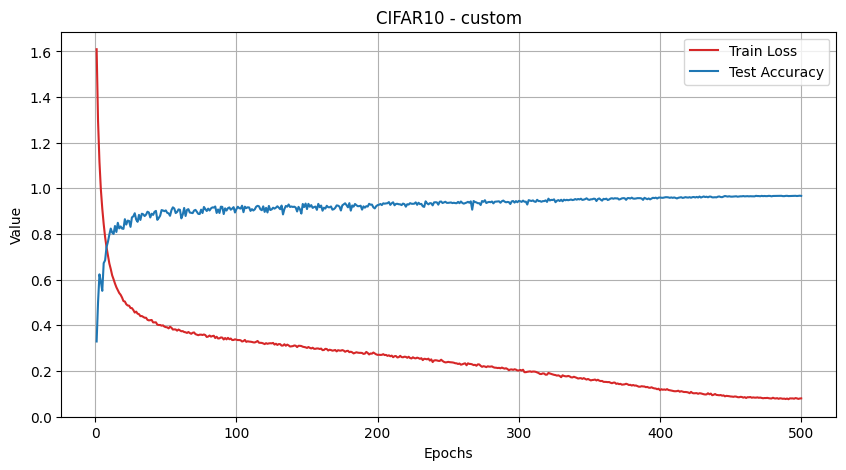

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 96.70 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 89.00 %


Accuracy of the network on gaussian_noise dataset split 2: 77.36 %


Accuracy of the network on gaussian_noise dataset split 3: 61.56 %


Accuracy of the network on gaussian_noise dataset split 4: 54.06 %


Accuracy of the network on gaussian_noise dataset split 5: 47.01 %
Average accuracy for gaussian_noise dataset: 65.80 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 92.86 %


Accuracy of the network on shot_noise dataset split 2: 88.06 %


Accuracy of the network on shot_noise dataset split 3: 73.55 %


Accuracy of the network on shot_noise dataset split 4: 66.94 %


Accuracy of the network on shot_noise dataset split 5: 55.65 %
Average accuracy for shot_noise dataset: 75.41 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 95.05 %


Accuracy of the network on impulse_noise dataset split 2: 92.19 %


Accuracy of the network on impulse_noise dataset split 3: 87.69 %


Accuracy of the network on impulse_noise dataset split 4: 69.50 %


Accuracy of the network on impulse_noise dataset split 5: 48.12 %
Average accuracy for impulse_noise dataset: 78.51 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 96.66 %


Accuracy of the network on defocus_blur dataset split 2: 96.27 %


Accuracy of the network on defocus_blur dataset split 3: 95.24 %


Accuracy of the network on defocus_blur dataset split 4: 93.41 %


Accuracy of the network on defocus_blur dataset split 5: 88.13 %
Average accuracy for defocus_blur dataset: 93.94 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 83.23 %


Accuracy of the network on glass_blur dataset split 2: 84.06 %


Accuracy of the network on glass_blur dataset split 3: 85.41 %


Accuracy of the network on glass_blur dataset split 4: 68.96 %


Accuracy of the network on glass_blur dataset split 5: 71.16 %
Average accuracy for glass_blur dataset: 78.56 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 95.04 %


Accuracy of the network on motion_blur dataset split 2: 92.10 %


Accuracy of the network on motion_blur dataset split 3: 87.65 %


Accuracy of the network on motion_blur dataset split 4: 87.18 %


Accuracy of the network on motion_blur dataset split 5: 82.15 %
Average accuracy for motion_blur dataset: 88.82 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 94.69 %


Accuracy of the network on zoom_blur dataset split 2: 94.41 %


Accuracy of the network on zoom_blur dataset split 3: 93.27 %


Accuracy of the network on zoom_blur dataset split 4: 91.68 %


Accuracy of the network on zoom_blur dataset split 5: 89.04 %
Average accuracy for zoom_blur dataset: 92.62 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 94.80 %


Accuracy of the network on snow dataset split 2: 90.47 %


Accuracy of the network on snow dataset split 3: 90.77 %


Accuracy of the network on snow dataset split 4: 88.70 %


Accuracy of the network on snow dataset split 5: 86.28 %
Average accuracy for snow dataset: 90.20 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 94.55 %


Accuracy of the network on frost dataset split 2: 91.94 %


Accuracy of the network on frost dataset split 3: 86.55 %


Accuracy of the network on frost dataset split 4: 84.79 %


Accuracy of the network on frost dataset split 5: 76.78 %
Average accuracy for frost dataset: 86.92 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 96.54 %


Accuracy of the network on fog dataset split 2: 96.03 %


Accuracy of the network on fog dataset split 3: 95.47 %


Accuracy of the network on fog dataset split 4: 93.62 %


Accuracy of the network on fog dataset split 5: 84.54 %
Average accuracy for fog dataset: 93.24 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 96.74 %


Accuracy of the network on brightness dataset split 2: 96.63 %


Accuracy of the network on brightness dataset split 3: 96.36 %


Accuracy of the network on brightness dataset split 4: 96.01 %


Accuracy of the network on brightness dataset split 5: 95.32 %
Average accuracy for brightness dataset: 96.21 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 96.42 %


Accuracy of the network on contrast dataset split 2: 95.56 %


Accuracy of the network on contrast dataset split 3: 94.66 %


Accuracy of the network on contrast dataset split 4: 93.29 %


Accuracy of the network on contrast dataset split 5: 85.49 %
Average accuracy for contrast dataset: 93.08 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 94.80 %


Accuracy of the network on elastic_transform dataset split 2: 94.84 %


Accuracy of the network on elastic_transform dataset split 3: 94.08 %


Accuracy of the network on elastic_transform dataset split 4: 90.55 %


Accuracy of the network on elastic_transform dataset split 5: 84.28 %
Average accuracy for elastic_transform dataset: 91.71 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 95.52 %


Accuracy of the network on pixelate dataset split 2: 92.65 %


Accuracy of the network on pixelate dataset split 3: 89.45 %


Accuracy of the network on pixelate dataset split 4: 73.99 %


Accuracy of the network on pixelate dataset split 5: 49.97 %
Average accuracy for pixelate dataset: 80.32 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 89.40 %


Accuracy of the network on jpeg_compression dataset split 2: 84.88 %


Accuracy of the network on jpeg_compression dataset split 3: 83.05 %


Accuracy of the network on jpeg_compression dataset split 4: 80.59 %


Accuracy of the network on jpeg_compression dataset split 5: 76.96 %
Average accuracy for jpeg_compression dataset: 82.98 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 92.73 %


Accuracy of the network on speckle_noise dataset split 2: 85.61 %


Accuracy of the network on speckle_noise dataset split 3: 80.53 %


Accuracy of the network on speckle_noise dataset split 4: 70.08 %


Accuracy of the network on speckle_noise dataset split 5: 59.90 %
Average accuracy for speckle_noise dataset: 77.77 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 96.62 %


Accuracy of the network on gaussian_blur dataset split 2: 95.20 %


Accuracy of the network on gaussian_blur dataset split 3: 93.68 %


Accuracy of the network on gaussian_blur dataset split 4: 91.63 %


Accuracy of the network on gaussian_blur dataset split 5: 85.56 %
Average accuracy for gaussian_blur dataset: 92.54 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 95.65 %


Accuracy of the network on spatter dataset split 2: 93.10 %


Accuracy of the network on spatter dataset split 3: 88.89 %


Accuracy of the network on spatter dataset split 4: 94.19 %


Accuracy of the network on spatter dataset split 5: 90.73 %
Average accuracy for spatter dataset: 92.51 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 95.53 %


Accuracy of the network on saturate dataset split 2: 93.88 %


Accuracy of the network on saturate dataset split 3: 96.44 %


Accuracy of the network on saturate dataset split 4: 95.39 %


Accuracy of the network on saturate dataset split 5: 93.99 %
Average accuracy for saturate dataset: 95.05 %
Average Robust Accuracy: 86.64 %


In [13]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=num_classes)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/CIFAR10_net_ta_custom_100.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")